In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
only_zeroes = X_train[y_train == 0]

In [5]:
only_zeroes.shape

(5923, 28, 28)

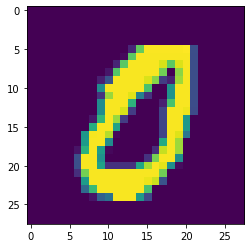

In [6]:
plt.imshow(only_zeroes[10])

In [7]:
only_zeroes = only_zeroes/255

In [8]:
only_zeroes = only_zeroes.reshape(-1, 28, 28, 1) * 2. - 1.

In [9]:
only_zeroes.min()

-1.0

In [10]:
only_zeroes.max()

1.0

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
codings_size = 100

In [13]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))

generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation='relu'))

generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation='tanh'))

2022-04-29 17:28:39.758547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [15]:
GAN = Sequential([generator, discriminator])

In [16]:
discriminator.trainable = False

In [17]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [18]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [19]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

In [20]:
batch_size = 32

In [21]:
my_data = only_zeroes

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [23]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [24]:
generator, discriminator = GAN.layers
epochs = 15

for epoch in range(epochs):
    i = 0
    
    for X_batch in dataset:
        i += 1
        if i%100 == 0:
            print(f"Currently training on batch {i} of {len(my_data//batch_size)}")
        
        # Discriminator Training
        noise = tf.random.normal(shape=[batch_size, codings_size])
        gen_images = generator(noise)
        
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis = 0)
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        discriminator.trainable = False
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        # Generator Training
        noise = tf.random.normal(shape=[batch_size, codings_size])
        y2 = tf.constant([[1.]] * batch_size)
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("Training complete")

Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Currently training on batch 100 of 5923
Training complete


In [25]:
noise = tf.random.normal(shape=[10, 100])

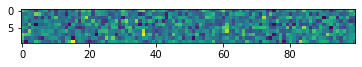

In [26]:
plt.imshow(noise)

In [27]:
gen_images = generator(noise)

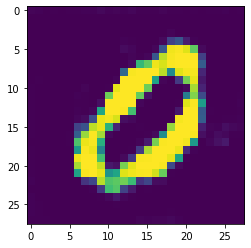

In [31]:
plt.imshow(gen_images[0].numpy())

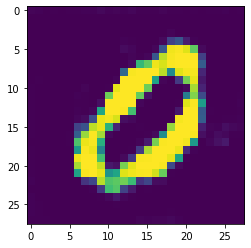

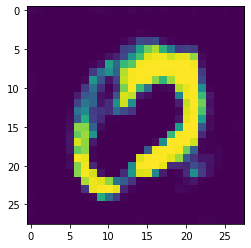

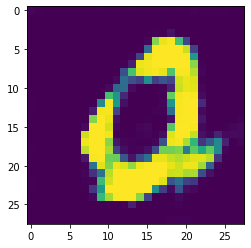

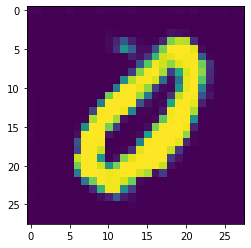

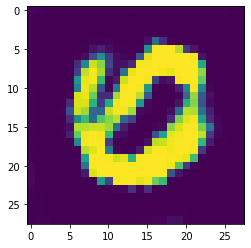

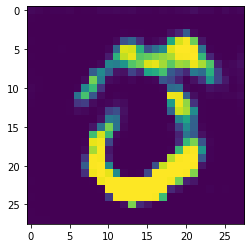

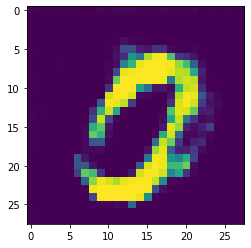

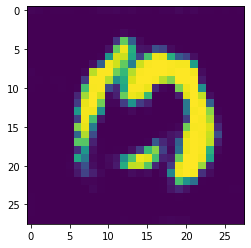

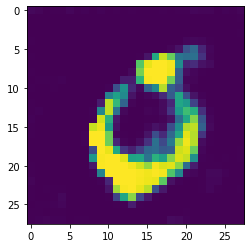

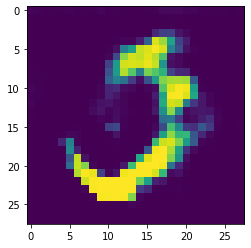

In [33]:
for image in gen_images:
    plt.imshow(image.numpy())
    plt.show()